In [1]:
import scipy.io
import numpy as np
from random import shuffle
import scipy.ndimage
import os
import scipy.io as io

data = "Indian_pines"

In [2]:
import scipy.io
import numpy as np
from random import shuffle
import scipy.ndimage
import os
import scipy.io as io

#from skimage import io

from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def F_tau(tau,M):
    '''
    minimize for M == X - L + Theta / rho
    given parameter tau == lambda / rho
    '''

    W = np.zeros_like(M)

    # cycle through columns
    for index, col in enumerate(M.T):
        y = np.linalg.norm(col)

        epsilon = (y-1)/2 + np.sqrt((1+y)**2/4 - tau + 0j)

        f_epsilon = (epsilon - y)**2/2 + tau*np.log(1 + epsilon + 0j)

        cond_f = f_epsilon <= y**2/2
        cond_y = (1+y)**2 > 4*tau

        w = epsilon*col*(cond_f & cond_y & (epsilon > 0)).astype(int)/y
        W[:, index] = np.real(w)
        
    return W

In [4]:
def D_tau(tau,M):
    #first calculate the SVD
    P, S, Qt = np.linalg.svd(M,full_matrices=False)

    #epsilon is a function of sigma and tau
    epsilon = (S-1)/2 + np.sqrt((1+S)**2/4 - tau + 0j)
    
    #evaluate f at x=0 and x=epsilon
    f_zero = S**2/2
    f_epsilon = (epsilon - S)**2/2 + tau*np.log(1+epsilon+0j)

    #define boolean arrays for S*
    cond_f = f_epsilon <= f_zero
    cond_S = (1+S)**2 > 4*tau
    
    #calculate S* and hence modify S
    S_star = np.real(epsilon * (cond_f & cond_S).astype(int))

    #return modified SVD
    return (P, S_star, Qt)

In [5]:
def RobustPCA(X, lamba, mu, tol, max_iter):
    
    M,N=np.shape(X)
    unobserved=np.isnan(X)
    X[unobserved]=0
    normX= np.linalg.norm(X,'fro')
    
    #intial solution
    L = np.zeros((M, N))
    S = np.zeros((M, N))
    Y = np.zeros((M, N))

    for iter in range(max_iter):
        
        U, S_mod, Vt = D_tau(1/mu, X - S + (1/mu)*Y)
        
        k=np.diag(S_mod)
        a=np.dot(U,k)
        L=np.dot(a,Vt)
        
        
        S = F_tau(lamb/mu, X - L + (1/mu)*Y)

        # and augmented lagrangian multiplier
        Z = X - L - S
        Z[unobserved] = 0; # skip missing values
        Y = Y + mu*Z

        err = np.linalg.norm(Z, 'fro') / normX
        outLine ="iter: %d\terr:%f\trank(L):%d\t" % (iter, err, matrix_rank(L))
        print(outLine)

        if err<tol:
            break
            
    return L,S

        
def So(tau,X):
    # Shrinkage Operator
    r = np.sign(X)*np.maximum(abs(X) - tau, 0)
    return r

def Do(tau,X):
    # Shrinkage operator for singular values
    U, S, V = np.linalg.svd(X,full_matrices=False)
    
    k=np.diag(So(tau,S))
    a=np.dot(U,k)
    r=np.dot(a,V)
    
    return r

In [7]:
input_mat = io.loadmat('Indian_pines.mat')['indian_pines']

In [8]:
HEIGHT = input_mat.shape[0]
WIDTH = input_mat.shape[1]
BAND = input_mat.shape[2]

In [9]:
input_mat[140].shape

(145, 220)

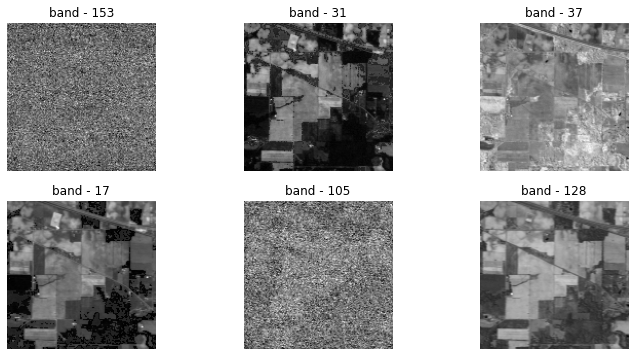

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.axes_style('whitegrid')
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(input_mat.shape[2])
    plt.imshow(input_mat[:,:,q], cmap='gray')
    plt.axis('off')
    plt.title(f'band - {q}')

Text(0.5, 1.0, 'band - 150')

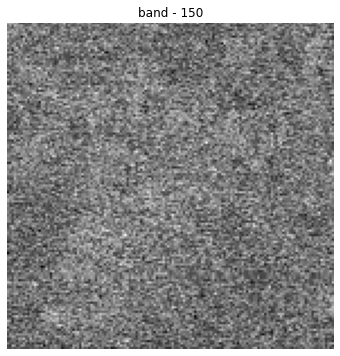

In [19]:
sns.axes_style('whitegrid')
fig = plt.figure(figsize = (12, 6))
plt.imshow(input_mat[:,:,149], cmap='gray')
plt.axis('off')
plt.title(f'band - {150}')

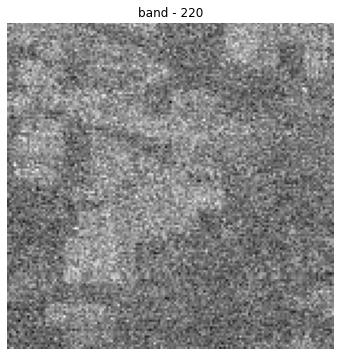

In [20]:
sns.axes_style('whitegrid')
fig = plt.figure(figsize = (12, 6))
plt.imshow(input_mat[:,:,219], cmap='gray')
plt.axis('off')
plt.title(f'band - {220}')
band_220th=input_mat[:,:,219]

In [21]:
M,N=band_220th.shape
print(M)
print(N)

img=band_220th

145
145


In [22]:
img_corrupted=img

In [24]:
ws = 5 # window size
no_patches = int(np.shape(band_220th)[0]/ws)
X = np.zeros((no_patches**2, ws**2))
k = 0
flag=0

In [25]:
np.shape(X)

(841, 25)

In [26]:
for i in range(1,no_patches*2):
    for j in range(1,no_patches*2):
        
        r1_start=int(1+(i-1)*ws/2)-1
        r1_end=int((i+1)*ws/2)
        
        r2_start=int(1+(j-1)*ws/2)-1
        r2_end=int((j+1)*ws/2)
        
        patch=img_corrupted[r1_start:r1_end,r2_start:r2_end]
        
        if k<81:
            X[k,:] = patch.ravel()
        
        else:
            X = np.vstack([X, patch.ravel()])
            
        k = k + 1

In [27]:
np.shape(X)

(4009, 25)

In [28]:
max_iter=1000
lamb = 1 / np.sqrt(max(M,N));
#lamb=0.02
#mu = 1.0;
mu = 10*lamb
tol = 1e-5

In [29]:
[L, S] = RobustPCA(X, lamb, mu, tol,max_iter)

iter: 0	err:0.000000	rank(L):25	


In [30]:
img_reconstructed = np.zeros(np.shape(img))
img_noise = np.zeros(np.shape(img))

In [45]:
k = 0
for i in range(1,no_patches*2):
    for j in range(1,no_patches*2):
        # average patches to get the image back from L and S
        # todo: in the borders less than 4 patches are averaged
        
        patch = np.reshape(L[k,:],(ws,ws))
        
        r1_start=int(1+(i-1)*ws/2)-1
        r1_end=int((i+1)*ws/2)
        
        r2_start=int(1+(j-1)*ws/2)-1
        r2_end=int((j+1)*ws/2)
        
        img_reconstructed[r1_start:r1_end,r2_start:r2_end] = img_reconstructed[r1_start:r1_end,r2_start:r2_end] + 0.25*patch
        
        
        patch = np.reshape(S[k,:],(ws,ws));
        img_noise[r1_start:r1_end,r2_start:r2_end] = img_noise[r1_start:r1_end,r2_start:r2_end] + 0.25*patch
        
        k = k + 1

img_final = img_reconstructed;
img_final[~np.isnan(img_corrupted)] = img_corrupted[~np.isnan(img_corrupted)]

Text(0.5, 1.0, 'Corrupted image')

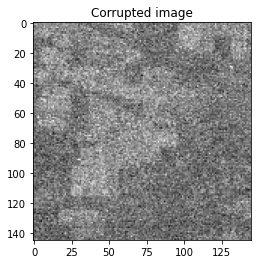

In [46]:
plt.imshow(img_corrupted,cmap='gray')
plt.title('Corrupted image')

Text(0.5, 1.0, 'Recovered image')

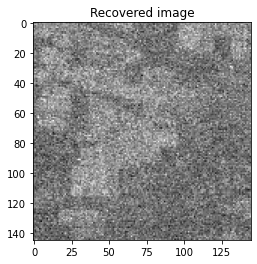

In [47]:
plt.imshow(img_final,cmap='gray')
plt.title('Recovered image')

Text(0.5, 1.0, 'Recovered low-rank')

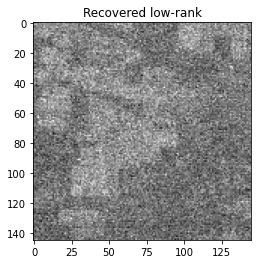

In [48]:
plt.imshow(img_reconstructed,cmap='gray')
plt.title('Recovered low-rank')

Text(0.5, 1.0, 'Recovered sparse')

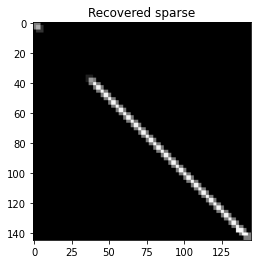

In [49]:
plt.imshow(img_noise,cmap='gray')
plt.title('Recovered sparse')